In [1]:
import pandas as pd
# import pyodbc
import logging
import requests
import copy
import math
import time
import nltk
from elasticsearch import helpers

from elasticsearch import Elasticsearch


In [2]:
df_materiais = pd.read_csv('df_materiais.csv')
df_materiais

,Unnamed: 0,ID_MATERIAL,TIPO,CODIGO_MATERIAL,ITEM_SUSPENSO,MATERIAL_SUSTENTAVEL,CODIGO_CLASSE,DESCRICAO_CLASSE,CODIGO_SUBCLASSE,DESCRICAO_SUBCLASSE,CODIGO_GRUPO,DESCRICAO_GRUPO,CODIGO_DIVISAO,DESCRICAO_DIVISAO,CODIGO_SECAO,DESCRICAO_SECAO,CARACTERISTICAS_BUSCA,NOME_MATERIAL,MATERIAL_TEXT
0,0,431550,M,600581,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Resistência Nominal 1k8OHMS Potência Nominal 1...,Resistor Carbono,Resistor Carbono Resistência Nominal 1k8OHMS P...
1,1,431551,M,600580,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
2,2,431552,M,600579,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
3,3,431553,M,600578,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
4,4,431554,M,600576,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Tipo Fixo Aplicação Eletrônica Resistência Nom...,Resistor Carbono,Resistor Carbono Tipo Fixo Aplicação Eletrônic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253861,253861,683446,M,377520,S,N,6145,FIOS E CABOS ELÉTRICOS,NaN,NaN,61,CONDUTORES ELÉTRICOS E EQUIPAMENTOS PARA GERAÇ...,NaN,NaN,NaN,NaN,Aplicação Uso Em Vídeo Características Adicion...,Cabo De Vídeo,Cabo De Vídeo Aplicação Uso Em Vídeo Caracterí...
253862,253862,683447,M,377519,S,N,6145,FIOS E CABOS ELÉTRICOS,NaN,NaN,61,CONDUTORES ELÉTRICOS E EQUIPAMENTOS PARA GERAÇ...,NaN,NaN,NaN,NaN,Aplicação Uso Em Vídeo N° De Cabos 3UN Tipo An...,Cabo De Vídeo,Cabo De Vídeo Aplicação Uso Em Vídeo N° De Cab...
253863,253863,683780,M,612103,N,N,6540,"EQUIPAMENTOS, INSTRUMENTOS E SUPRIMENTOS OFTAL...",NaN,NaN,65,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",NaN,NaN,NaN,NaN,Tipo Grande Ocular Modelo De Não Contato Aplic...,Sistema De Lentes Para Equipamento Oftalmológico,Sistema De Lentes Para Equipamento Oftalmológi...
253864,253864,683781,M,229763,N,N,6540,"EQUIPAMENTOS, INSTRUMENTOS E SUPRIMENTOS OFTAL...",NaN,NaN,65,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",NaN,NaN,NaN,NaN,Material Cristal Características Adicionais Au...,Sistema De Lentes Para Equipamento Oftalmológico,Sistema De Lentes Para Equipamento Oftalmológi...


In [2]:
# es = Elasticsearch(
#     "http://150.165.75.163:9200",
#     basic_auth=("elastic", "GnlrL41DQapI3"),
#     request_timeout=999999999
# )

# es.info()
es = Elasticsearch(
    "http://150.165.75.163:9202",
    basic_auth=("elastic", "teste123"),
    request_timeout=999999999
)

es.info()


ObjectApiResponse({'name': 'es01', 'cluster_name': 'es-docker-cluster', 'cluster_uuid': '8pFe7X9oRge9WST4LcJmzw', 'version': {'number': '8.6.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2d58d0f136141f03239816a4e360a8d17b6d8f29', 'build_date': '2023-02-13T09:35:20.314882762Z', 'build_snapshot': False, 'lucene_version': '9.4.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [3]:
from sentence_transformers import SentenceTransformer
modelL6V2 = SentenceTransformer('all-MiniLM-L6-v2')
modelBV2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
modelMult = SentenceTransformer('sentence-transformers/quora-distilbert-multilingual')
modelLASE = SentenceTransformer('sentence-transformers/LaBSE')

/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is

In [4]:
df_index_catmat = pd.read_csv('df_index_catmat_resample.csv')
df_index_catmat

/tmp/ipykernel_954151/1942492608.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_index_catmat = pd.read_csv('df_index_catmat_resample.csv')


,Unnamed: 0.1,Unnamed: 0,ID_MATERIAL,TIPO,CODIGO_MATERIAL,ITEM_SUSPENSO,MATERIAL_SUSTENTAVEL,CODIGO_CLASSE,DESCRICAO_CLASSE,CODIGO_SUBCLASSE,DESCRICAO_SUBCLASSE,CODIGO_GRUPO,DESCRICAO_GRUPO,CODIGO_DIVISAO,DESCRICAO_DIVISAO,CODIGO_SECAO,DESCRICAO_SECAO,CARACTERISTICAS_BUSCA,NOME_MATERIAL,MATERIAL_TEXT
0,0,0.0,431550,M,600581.0,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Resistência Nominal 1k8OHMS Potência Nominal 1...,Resistor Carbono,Resistor Carbono Resistência Nominal 1k8OHMS P...
1,1,1.0,431551,M,600580.0,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
2,2,2.0,431552,M,600579.0,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
3,3,3.0,431553,M,600578.0,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Potência Nominal 1UN Tipo Fixo Aplicação Eletr...,Resistor Carbono,Resistor Carbono Potência Nominal 1UN Tipo Fix...
4,4,4.0,431554,M,600576.0,N,N,5905,RESISTORES,NaN,NaN,59,COMPONENTES DE EQUIPAMENTOS ELÉTRICOS E ELETRÔ...,NaN,NaN,NaN,NaN,Tipo Fixo Aplicação Eletrônica Resistência Nom...,Resistor Carbono,Resistor Carbono Tipo Fixo Aplicação Eletrônic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244333,253811,253861.0,683446,M,377520.0,S,N,6145,FIOS E CABOS ELÉTRICOS,NaN,NaN,61,CONDUTORES ELÉTRICOS E EQUIPAMENTOS PARA GERAÇ...,NaN,NaN,NaN,NaN,Aplicação Uso Em Vídeo Características Adicion...,Cabo De Vídeo,Cabo De Vídeo Aplicação Uso Em Vídeo Caracterí...
244334,253812,253862.0,683447,M,377519.0,S,N,6145,FIOS E CABOS ELÉTRICOS,NaN,NaN,61,CONDUTORES ELÉTRICOS E EQUIPAMENTOS PARA GERAÇ...,NaN,NaN,NaN,NaN,Aplicação Uso Em Vídeo N° De Cabos 3UN Tipo An...,Cabo De Vídeo,Cabo De Vídeo Aplicação Uso Em Vídeo N° De Cab...
244335,253813,253863.0,683780,M,612103.0,N,N,6540,"EQUIPAMENTOS, INSTRUMENTOS E SUPRIMENTOS OFTAL...",NaN,NaN,65,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",NaN,NaN,NaN,NaN,Tipo Grande Ocular Modelo De Não Contato Aplic...,Sistema De Lentes Para Equipamento Oftalmológico,Sistema De Lentes Para Equipamento Oftalmológi...
244336,253814,253864.0,683781,M,229763.0,N,N,6540,"EQUIPAMENTOS, INSTRUMENTOS E SUPRIMENTOS OFTAL...",NaN,NaN,65,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",NaN,NaN,NaN,NaN,Material Cristal Características Adicionais Au...,Sistema De Lentes Para Equipamento Oftalmológico,Sistema De Lentes Para Equipamento Oftalmológi...


In [6]:
sample_catmat = pd.read_csv('sample_catmat_test.csv')
sample_catmat['relevantes'] = None
for idx, query in sample_catmat.iterrows():
    nome_mater = query['NOME_MATERIAL']
    results_descricao = df_index_catmat[df_index_catmat['NOME_MATERIAL'] == nome_mater]
    sample_catmat['relevantes'][idx] = [(row['ID_MATERIAL'], 2) for _, row in results_descricao.iterrows()]
sample_catmat = sample_catmat[['ID_MATERIAL', 'NOME_MATERIAL', 'MATERIAL_TEXT', 'relevantes']]
sample_catmat
    

/tmp/ipykernel_4056369/161056476.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sample_catmat['relevantes'][idx] = [(row['ID_MATERIAL'], 2) for _, row in results_descricao.iterrows()]
/tmp/ipykernel_4056369/161056476.py:6: SettingWithCo

,ID_MATERIAL,NOME_MATERIAL,MATERIAL_TEXT,relevantes
0,508151,Bloco,Bloco Altura 19POL Argila Comprimento 29T Larg...,"[(508149, 2), (508150, 2)]"
1,581197,Retroescavadeira,Retroescavadeira Potência Operacional Mínima 8...,"[(581196, 2), (581198, 2), (581199, 2), (58120..."
2,475502,Bandeja Revelação,Bandeja Revelação Plástico Ranhuras Fundo E Ap...,"[(475494, 2), (475495, 2), (475496, 2), (47549..."
3,476587,Forno Mufla,Forno Mufla Aplicação Tratamento Térmico Tempe...,"[(476574, 2), (476575, 2), (476576, 2), (47657..."
4,476635,Retificador Soldagem,Retificador Soldagem Alimentação 220/380/440VC...,"[(476631, 2), (476632, 2), (476633, 2), (47663..."
5,476644,Máquina Solda Portátil,Máquina Solda Portátil Freqüência Nominal 50/6...,"[(476637, 2), (476638, 2), (476639, 2), (47664..."
6,476989,Empilhadeira Elétrica,Empilhadeira Elétrica Capacidade 1.500VA Corre...,"[(476987, 2), (476988, 2), (476990, 2), (47699..."
7,478509,Serra Portátil,Serra Portátil Tipo Sabre Quantidade Golpes Po...,"[(478504, 2), (478505, 2), (478506, 2), (47850..."
8,480052,Estação Solda,Estação Solda Tensão Alimentação 110/220V Form...,"[(480046, 2), (480047, 2), (480048, 2), (48004..."
9,497941,Alvo De Tiro,Alvo De Tiro Papel Cartão Tipo Quadrado Tamanh...,"[(497934, 2), (497935, 2), (497936, 2), (49793..."


In [7]:
dv_relev_novo = sample_catmat.reset_index(drop =True)
# dv_relev_novo['CODIGO_BARRA']

In [8]:
dv_relev_novo

,ID_MATERIAL,NOME_MATERIAL,MATERIAL_TEXT,relevantes
0,508151,Bloco,Bloco Altura 19POL Argila Comprimento 29T Larg...,"[(508149, 2), (508150, 2)]"
1,581197,Retroescavadeira,Retroescavadeira Potência Operacional Mínima 8...,"[(581196, 2), (581198, 2), (581199, 2), (58120..."
2,475502,Bandeja Revelação,Bandeja Revelação Plástico Ranhuras Fundo E Ap...,"[(475494, 2), (475495, 2), (475496, 2), (47549..."
3,476587,Forno Mufla,Forno Mufla Aplicação Tratamento Térmico Tempe...,"[(476574, 2), (476575, 2), (476576, 2), (47657..."
4,476635,Retificador Soldagem,Retificador Soldagem Alimentação 220/380/440VC...,"[(476631, 2), (476632, 2), (476633, 2), (47663..."
5,476644,Máquina Solda Portátil,Máquina Solda Portátil Freqüência Nominal 50/6...,"[(476637, 2), (476638, 2), (476639, 2), (47664..."
6,476989,Empilhadeira Elétrica,Empilhadeira Elétrica Capacidade 1.500VA Corre...,"[(476987, 2), (476988, 2), (476990, 2), (47699..."
7,478509,Serra Portátil,Serra Portátil Tipo Sabre Quantidade Golpes Po...,"[(478504, 2), (478505, 2), (478506, 2), (47850..."
8,480052,Estação Solda,Estação Solda Tensão Alimentação 110/220V Form...,"[(480046, 2), (480047, 2), (480048, 2), (48004..."
9,497941,Alvo De Tiro,Alvo De Tiro Papel Cartão Tipo Quadrado Tamanh...,"[(497934, 2), (497935, 2), (497936, 2), (49793..."


In [20]:
# !export GROQ_API_KEY="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"
from groq import Groq
import os
os.environ['GROQ_API_KEY'] = "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"
api_key = os.environ.get("GROQ_API_KEY")
print(f"GROQ_API_KEY: {api_key}")
import datetime

GROQ_API_KEY: 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


In [23]:
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

def generate_synonym_descriptions(df):
    instructions = """
    ### Instruções:
    Abaixo você receberá descrições de produtos. Para cada descrição, gere apenas uma variação que se refere ao mesmo produto, respeitando os valores como altura, profundidade e volume. As unidades de medida podem ser substituídas por sua nomenclatura por extenso (por exemplo, cm para "centímetros").

    ### Exemplos:

    #### Exemplo 1:
    #### Descrição original:
    Forno Mufla Aplicação Tratamento Térmico Temperatura Máxima 1.400V Largura 600MBPS Altura 400V Profundidade 680MMHG Volume 163MM

    #### Variações:
    1. Forno Mufla para Tratamento Térmico com Temperatura Máxima de 1.400 Volts, Largura de 600 Megabits por Segundo, Altura de 400 Volts, Profundidade de 680 Milímetros de Mercúrio e Volume de 163 Milímetros
    2. Forno Mufla para Processos Térmicos, alcançando até 1.400V, com Largura de 600MBPS, Altura de 400V, Profundidade de 680MMHG e Volume de 163MM
    3. Forno Mufla adequado para Tratamento Térmico com Temperatura Máxima de 1.400V, Largura de 600MBPS, Altura de 400V, Profundidade de 680MMHG e Volume de 163MM

    #### Exemplo 2:
    #### Descrição original:
    Geladeira Industrial Capacidade 500L Temperatura mínima -20°C Temperatura máxima 10°C Consumo energético 200W Dimensões 180X70X60CM Peso 80KG

    #### Variações:
    1. Geladeira Industrial com Capacidade de 500 Litros, Temperatura Mínima de -20 Graus Celsius e Máxima de 10 Graus Celsius, Consumo Energético de 200 Watts, Dimensões de 180 por 70 por 60 Centímetros e Peso de 80 Quilogramas
    2. Refrigerador Industrial com Volume de 500L, suportando Temperaturas de -20°C a 10°C, Consumo de Energia de 200W, Medidas de 180X70X60CM e Peso de 80KG
    3. Unidade de Refrigeração Industrial com Capacidade de 500L, operando entre -20°C e 10°C, Consumo de 200W, Dimensões de 180X70X60CM e Massa de 80KG

    ### Agora, gere um prompt de resposta sem nenhuma mensagem de introdução, apenas apresente uma resposta no seguinte formato:
    1.
    Gere apenas uma descrição contendo sinônimos para o seguinte produto:
    """

    data = []

    for index, row in df.iterrows():
        product_description = f"####\n{row['MATERIAL_TEXT']}\n\n####:\n"
        completion = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {
                    "role": "user",
                    "content": instructions + product_description
                }
            ],
            temperature=0.9,
            max_tokens=2048,
            top_p=0.95,
            stream=False,
            stop=None,
        )
        
        generated_variation = completion.choices[0].message.content.strip()
        print(generated_variation)

        data.append({
            "query": row['MATERIAL_TEXT'],
            "com_sinonimos": generated_variation
        })

        data.append({
            "query": row['MATERIAL_TEXT'],
            "com_sinonimos": generated_variation
        })
    
        data.append({
            "query": row['MATERIAL_TEXT'],
            "com_sinonimos": generated_variation
        })

        data.append({
            "query": row['MATERIAL_TEXT'],
            "com_sinonimos": generated_variation
        })
        
    df_sinonimo = pd.DataFrame(data)
    
    return df_sinonimo



In [24]:
df_sinonimos = generate_synonym_descriptions(dv_relev_novo)
df_sinonimos

1. Módulo de Argila com Altura de 19 Polegadas, Comprimento de 29 Toneladas, Largura de 14 Unidades e Compressão Mínima de 2,5 Megapascals.
1. Retroescavadeira com Potência Operacional Mínima de 85 Megassons, Peso Vazio de 6.800 Quilogramas, Capacidade Mínima de Carregadeira de 0,96 Metros Cúbicos e Capacidade Mínima de Escavadeira de 0,30 Metros Quadrados.
1. Bandeja de Revelação feita de Plástico com Ranhuras no Fundo e Suporte para Termômetro, apresentando uma Altura de 7 Litros por Minuto, Comprimento de 18 Polegadas, Largura de 13 Polegadas e Cor Bege.
1. Forno de Tratamento Térmico para Aplicação Industrial com Temperatura Máxima de 1.400 Volts, Largura de 600 Megabits por Segundo, Altura de 400 Volts, Profundidade de 680 Milímetros de Mercúrio e Volume de 163 Milímetros
1. Fonte de Alimentação para Soldagem com Tensão de Entrada de 220/380/440 Volts CA, Frequência de 60 Hertz, Capacidade de Soldagem com Eletrodos de até 6 Milímetros de Diâmetro, Corrente de 400 Volts e Peso de 2

,query,com_sinonimos
0,Bloco Altura 19POL Argila Comprimento 29T Larg...,1. Módulo de Argila com Altura de 19 Polegadas...
1,Bloco Altura 19POL Argila Comprimento 29T Larg...,1. Módulo de Argila com Altura de 19 Polegadas...
2,Bloco Altura 19POL Argila Comprimento 29T Larg...,1. Módulo de Argila com Altura de 19 Polegadas...
3,Bloco Altura 19POL Argila Comprimento 29T Larg...,1. Módulo de Argila com Altura de 19 Polegadas...
4,Retroescavadeira Potência Operacional Mínima 8...,1. Retroescavadeira com Potência Operacional M...
...,...,...
195,Acoplamento Elástico Poliuretano Modelo Ômega ...,1. Conjunto Elástico de Poliuretano Modelo Ôme...
196,Anticorrosivo Apresentação Líquido Aspecto Fís...,1. Produto Anticorrosivo em Formato Líquido co...
197,Anticorrosivo Apresentação Líquido Aspecto Fís...,1. Produto Anticorrosivo em Formato Líquido co...
198,Anticorrosivo Apresentação Líquido Aspecto Fís...,1. Produto Anticorrosivo em Formato Líquido co...


In [26]:
import pandas as pd

def tratar_descricao(df, coluna):
    def remover_prefixo(descricao):
        if descricao.startswith("1. "):
            return descricao[3:]
        return descricao

    df[coluna] = df[coluna].apply(remover_prefixo)
    return df


In [27]:
df_sinonimos_llam = tratar_descricao(df_sinonimos, 'com_sinonimos')
df_sinonimos_llam

,query,com_sinonimos
0,Bloco Altura 19POL Argila Comprimento 29T Larg...,"Módulo de Argila com Altura de 19 Polegadas, C..."
1,Bloco Altura 19POL Argila Comprimento 29T Larg...,"Módulo de Argila com Altura de 19 Polegadas, C..."
2,Bloco Altura 19POL Argila Comprimento 29T Larg...,"Módulo de Argila com Altura de 19 Polegadas, C..."
3,Bloco Altura 19POL Argila Comprimento 29T Larg...,"Módulo de Argila com Altura de 19 Polegadas, C..."
4,Retroescavadeira Potência Operacional Mínima 8...,Retroescavadeira com Potência Operacional Míni...
...,...,...
195,Acoplamento Elástico Poliuretano Modelo Ômega ...,Conjunto Elástico de Poliuretano Modelo Ômega ...
196,Anticorrosivo Apresentação Líquido Aspecto Fís...,Produto Anticorrosivo em Formato Líquido com A...
197,Anticorrosivo Apresentação Líquido Aspecto Fís...,Produto Anticorrosivo em Formato Líquido com A...
198,Anticorrosivo Apresentação Líquido Aspecto Fís...,Produto Anticorrosivo em Formato Líquido com A...


In [28]:
df_sinonimos_llam.to_csv('ruidosCsvEmbeddings/sinonimos_llama.csv')

In [9]:
queries = []
for idx, row in dv_relev_novo.iterrows():
    queries.append({'idx':idx,'query': row['MATERIAL_TEXT'], 'page_size': 100})

result_queries = []
for q in queries:
     q_allmini = copy.deepcopy(q)
     q_allmini['abordagem'] = 'all_mini'
     result_queries.append(q_allmini)
     
     q_bv2 = copy.deepcopy(q)
     q_bv2['abordagem'] = 'q_bv2'
     result_queries.append(q_bv2)

     q_mpnet = copy.deepcopy(q)
     q_mpnet['abordagem'] = 'mpnet'
     result_queries.append(q_mpnet)
     
     q_labase = copy.deepcopy(q)
     q_labase['abordagem'] = 'labase'
     result_queries.append(q_labase)

df_queries_relv = pd.DataFrame(result_queries)
df_queries_relv

,idx,query,page_size,abordagem
0,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,all_mini
1,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,q_bv2
2,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,mpnet
3,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,labase
4,1,Retroescavadeira Potência Operacional Mínima 8...,100,all_mini
...,...,...,...,...
195,48,Acoplamento Elástico Poliuretano Modelo Ômega ...,100,labase
196,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,all_mini
197,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,q_bv2
198,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,mpnet


In [10]:
df_sinonimos_llam = pd.read_csv('ruidosCsvEmbeddings/sinonimos_llama.csv')
df_erros_dig = pd.read_csv('erros_digitacao_resample.csv')
df_termos_reord = pd.read_csv('reordenados_resample.csv')


In [11]:
df_queries_relv['sinonimos'] = df_sinonimos_llam['com_sinonimos']
df_queries_relv['erros_digitacao'] = df_erros_dig['erros_digitacao']
df_queries_relv['reordenados'] = df_termos_reord['reordenados']
df_queries_relv

,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados
0,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,all_mini,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...
1,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,q_bv2,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...
2,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,mpnet,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...
3,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,labase,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...
4,1,Retroescavadeira Potência Operacional Mínima 8...,100,all_mini,Retroescavadeira com Potência Operacional Míni...,Retroescavadeira Potência Operacnal Mínima 85M...,Retroescavadeira Peso Vazia 6.800KG Potência O...
...,...,...,...,...,...,...,...
195,48,Acoplamento Elástico Poliuretano Modelo Ômega ...,100,labase,Conjunto Elástico de Poliuretano Modelo Ômega ...,Acoplamento Elástico Poliureteno Modelo Ômega ...,Poliuretano Modelo Ômega E70m Acoplamento Elás...
196,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,all_mini,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...
197,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,q_bv2,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...
198,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,mpnet,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...


In [12]:
df_queries_relv.isnull().sum()

idx                0
query              0
page_size          0
abordagem          0
sinonimos          0
erros_digitacao    0
reordenados        0
dtype: int64

In [13]:
df_queries_relv.to_csv('ruidosCsvEmbeddings/queries_teste_embeddings_catmat.csv')


In [15]:
from requests.auth import HTTPBasicAuth
logging.basicConfig(filename= 'experiment_relv_embeddings_catmat.log',
    filemode='a',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.DEBUG)

def run(file):
    total_time = 0
    processed_queries = 0
    experiment_queries = pd.read_csv(file)
    for key, value in experiment_queries.iterrows():
        if(key % 20 == 0):
            print('key', key)
        # print('value', value)

        logging.info(f'Iniciando processamento da query {value["query"]} com pagina de tamanho {value["page_size"]}')
        try:
            for i in ['query', 'sinonimos', 'erros_digitacao', 'reordenados']:
                match_query = ''
                query = ''        
                if(value['abordagem']) == 'all_mini':
                    index_consulta = 'mat_semaanc'
                    match_query = modelL6V2.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'all_mini_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }
                elif(value['abordagem']) == 'q_bv2':
                    index_consulta = 'mat_semaanc'
                    match_query = modelBV2.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'bv2_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }

                elif(value['abordagem']) == 'mpnet':
                    index_consulta = 'mat_semaanc'
                    match_query = modelMult.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'mpnet_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }
                elif(value['abordagem']) == 'labase':
                    index_consulta = 'mat_semaanc'
                    match_query = modelLASE.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'labase_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }    

                # else:
                #     index_consulta = 'index_lex_nf'
                #     match_query = value[i]
                    
                #     query = {
                #         "query": {
                #             "match": {
                #                 "descricao_produto": match_query
                #             }
                #         },"size": 100
                #     }              
        
                sucess = False
                retry_times = 0
                # print('abordagem', value['abordagem'])

                while(not sucess and retry_times < 10):

                    start_time = time.perf_counter()
                    result = requests.get('http://150.165.75.163:9202/' + index_consulta + '/_search', json=query, headers={'Content-type': 'application/json'},
                                          auth=HTTPBasicAuth('elastic', 'teste123'))
                    time_elapsed = time.perf_counter() - start_time
                    total_time += time_elapsed
                    print('result', result)

                    if result.status_code == requests.codes.ok:
                        sucess = True
                    else:
                        retry_times += 1
                    # print('result', result)
                processed_queries += 1
                result_query = 'result_' + i 
                # print('query', result.content)

                experiment_queries.loc[key, result_query] = result.content.decode('utf-8')

                remaining_time = (total_time / processed_queries) * (len(experiment_queries) - processed_queries)

                logging.info(f'A query levou {time_elapsed:.6f}s')
                logging.info(f'Faltam aproximadamente {int(remaining_time // 3600)}h, {int((remaining_time % 3600) // 60)}m e {math.floor(remaining_time % 60)}s')
            
        except Exception as error:
            logging.error(f'Erro na consulta: {error}')
    experiment_queries.to_csv('queries_result_relv_embd_catmat.csv')



In [16]:
run('/mnt/DADOS/melqui/busca-smt/ruidosCsvEmbeddings/queries_teste_embeddings_catmat.csv')

key 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 20


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 40


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 60


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 80


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 120


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 140


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 160


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>
key 180


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

result <Response [200]>


In [8]:
results = pd.read_csv('queries_result_relv_embd_catmat.csv')
results

,Unnamed: 0.1,Unnamed: 0,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados,result_query,result_sinonimos,result_erros_digitacao,result_reordenados
0,0,0,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,all_mini,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{""took"":287,""timed_out"":false,""_shards"":{""tota...","{""took"":84,""timed_out"":false,""_shards"":{""total...","{""took"":67,""timed_out"":false,""_shards"":{""total...","{""took"":63,""timed_out"":false,""_shards"":{""total..."
1,1,1,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,q_bv2,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{""took"":441,""timed_out"":false,""_shards"":{""tota...","{""took"":128,""timed_out"":false,""_shards"":{""tota...","{""took"":106,""timed_out"":false,""_shards"":{""tota...","{""took"":129,""timed_out"":false,""_shards"":{""tota..."
2,2,2,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,mpnet,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{""took"":549,""timed_out"":false,""_shards"":{""tota...","{""took"":138,""timed_out"":false,""_shards"":{""tota...","{""took"":123,""timed_out"":false,""_shards"":{""tota...","{""took"":110,""timed_out"":false,""_shards"":{""tota..."
3,3,3,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,labase,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{""took"":499,""timed_out"":false,""_shards"":{""tota...","{""took"":130,""timed_out"":false,""_shards"":{""tota...","{""took"":122,""timed_out"":false,""_shards"":{""tota...","{""took"":117,""timed_out"":false,""_shards"":{""tota..."
4,4,4,1,Retroescavadeira Potência Operacional Mínima 8...,100,all_mini,Retroescavadeira com Potência Operacional Míni...,Retroescavadeira Potência Operacnal Mínima 85M...,Retroescavadeira Peso Vazia 6.800KG Potência O...,"{""took"":84,""timed_out"":false,""_shards"":{""total...","{""took"":72,""timed_out"":false,""_shards"":{""total...","{""took"":63,""timed_out"":false,""_shards"":{""total...","{""took"":67,""timed_out"":false,""_shards"":{""total..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,48,Acoplamento Elástico Poliuretano Modelo Ômega ...,100,labase,Conjunto Elástico de Poliuretano Modelo Ômega ...,Acoplamento Elástico Poliureteno Modelo Ômega ...,Poliuretano Modelo Ômega E70m Acoplamento Elás...,"{""took"":109,""timed_out"":false,""_shards"":{""tota...","{""took"":114,""timed_out"":false,""_shards"":{""tota...","{""took"":104,""timed_out"":false,""_shards"":{""tota...","{""took"":107,""timed_out"":false,""_shards"":{""tota..."
196,196,196,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,all_mini,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...,"{""took"":60,""timed_out"":false,""_shards"":{""total...","{""took"":58,""timed_out"":false,""_shards"":{""total...","{""took"":68,""timed_out"":false,""_shards"":{""total...","{""took"":63,""timed_out"":false,""_shards"":{""total..."
197,197,197,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,q_bv2,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...,"{""took"":116,""timed_out"":false,""_shards"":{""tota...","{""took"":116,""timed_out"":false,""_shards"":{""tota...","{""took"":108,""timed_out"":false,""_shards"":{""tota...","{""took"":110,""timed_out"":false,""_shards"":{""tota..."
198,198,198,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,mpnet,Produto Anticorrosivo em Formato

In [9]:
results.isnull().sum()

Unnamed: 0.1              0
Unnamed: 0                0
idx                       0
query                     0
page_size                 0
abordagem                 0
sinonimos                 0
erros_digitacao           0
reordenados               0
result_query              0
result_sinonimos          0
result_erros_digitacao    0
result_reordenados        0
dtype: int64

In [10]:
import json
for i in ['query', 'sinonimos', 'erros_digitacao', 'reordenados']:
    result_query = 'result_' + i
    # print(result_query)
    # print(results[result_query])
    results[result_query] = results.apply(lambda row: json.loads(row[result_query]), axis=1)

# MÉTRICAS

In [11]:
def precision(results, expected):
    hits = 0
    lista = [x[0] for x in expected]
    for result in results:
        if result['id_material'] in lista:
            hits += 1
    if len(results) == 0:
        return 0
    precision_value = hits / len(results)
    return precision_value


In [12]:
def recall(results, expected, abordagem):
    expected_ids = set(map(lambda x: x[0], expected))
    returned_ids = set(map(lambda x: x['id_material'], results))
    intersection = expected_ids.intersection(returned_ids)
    recaal = len(intersection) / len(expected) if len(expected) > 0 else 0
   
    return recaal


In [13]:
def is_similar(desc1, desc2):
    vectors = tfidf_vectorizer.transform([desc1, desc2])

    vector_emb1 = modelL6V2.encode(desc1) 
    vector_emb1 = vector_emb1.reshape(1, -1)

    vector_emb2 = modelL6V2.encode(desc2)
    vector_emb2 = vector_emb2.reshape(1, -1)
    
    cosine_dist_emb = cosine_similarity(vector_emb1, vector_emb2)
    cosine_dist_tf_idf = cosine_similarity(vectors[0], vectors[1])
    value_cosi =  max(cosine_dist_tf_idf, cosine_dist_emb)
    if value_cosi > 0.7:
        return True
    else:
        return 

In [14]:
def ndcg(results, expected, query):
    annoted_results = []
    for result in results:
        r_copy = copy.deepcopy(result)
        filtered = list(filter(lambda x: x[0] == result['id_material'], expected))
        r_copy['relevance'] = filtered[0][1] if len(filtered) > 0 else 1 if is_similar(result['material_text'], query) else 0
        #r_copy['relevance'] = filtered[0][1] if len(filtered) > 0 else 0
        annoted_results.append(r_copy)
    
    dcg = 0
    idcg = 0
    sorted_results = sorted(annoted_results, key=lambda x: x['relevance'], reverse=True)
    for i in range(len(results)):
        dcg += (2**annoted_results[i]['relevance'] - 1) / math.log2(i + 2)
        idcg += (2**sorted_results[i]['relevance'] - 1) / math.log2(i + 2)
    if idcg == 0: return 0
    return dcg / idcg

In [15]:
results

,Unnamed: 0.1,Unnamed: 0,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados,result_query,result_sinonimos,result_erros_digitacao,result_reordenados
0,0,0,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,all_mini,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{'took': 287, 'timed_out': False, '_shards': {...","{'took': 84, 'timed_out': False, '_shards': {'...","{'took': 67, 'timed_out': False, '_shards': {'...","{'took': 63, 'timed_out': False, '_shards': {'..."
1,1,1,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,q_bv2,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{'took': 441, 'timed_out': False, '_shards': {...","{'took': 128, 'timed_out': False, '_shards': {...","{'took': 106, 'timed_out': False, '_shards': {...","{'took': 129, 'timed_out': False, '_shards': {..."
2,2,2,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,mpnet,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{'took': 549, 'timed_out': False, '_shards': {...","{'took': 138, 'timed_out': False, '_shards': {...","{'took': 123, 'timed_out': False, '_shards': {...","{'took': 110, 'timed_out': False, '_shards': {..."
3,3,3,0,Bloco Altura 19POL Argila Comprimento 29T Larg...,100,labase,"Módulo de Argila com Altura de 19 Polegadas, C...",Bloco Altura 19POL Argila Comprimento 29T Larg...,Bloco Altura 19POL Largura 14UN Argila Comprim...,"{'took': 499, 'timed_out': False, '_shards': {...","{'took': 130, 'timed_out': False, '_shards': {...","{'took': 122, 'timed_out': False, '_shards': {...","{'took': 117, 'timed_out': False, '_shards': {..."
4,4,4,1,Retroescavadeira Potência Operacional Mínima 8...,100,all_mini,Retroescavadeira com Potência Operacional Míni...,Retroescavadeira Potência Operacnal Mínima 85M...,Retroescavadeira Peso Vazia 6.800KG Potência O...,"{'took': 84, 'timed_out': False, '_shards': {'...","{'took': 72, 'timed_out': False, '_shards': {'...","{'took': 63, 'timed_out': False, '_shards': {'...","{'took': 67, 'timed_out': False, '_shards': {'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,48,Acoplamento Elástico Poliuretano Modelo Ômega ...,100,labase,Conjunto Elástico de Poliuretano Modelo Ômega ...,Acoplamento Elástico Poliureteno Modelo Ômega ...,Poliuretano Modelo Ômega E70m Acoplamento Elás...,"{'took': 109, 'timed_out': False, '_shards': {...","{'took': 114, 'timed_out': False, '_shards': {...","{'took': 104, 'timed_out': False, '_shards': {...","{'took': 107, 'timed_out': False, '_shards': {..."
196,196,196,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,all_mini,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...,"{'took': 60, 'timed_out': False, '_shards': {'...","{'took': 58, 'timed_out': False, '_shards': {'...","{'took': 68, 'timed_out': False, '_shards': {'...","{'took': 63, 'timed_out': False, '_shards': {'..."
197,197,197,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,q_bv2,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...,"{'took': 116, 'timed_out': False, '_shards': {...","{'took': 116, 'timed_out': False, '_shards': {...","{'took': 108, 'timed_out': False, '_shards': {...","{'took': 110, 'timed_out': False, '_shards': {..."
198,198,198,49,Anticorrosivo Apresentação Líquido Aspecto Fís...,100,mpnet,Produto Anticorrosivo em Formato Líquido com A...,Anticorrosivo Apresentação Líquido Aspecto Fís...,Apresentação Líquido Aspecto Físico Anticorros...,"{'took': 115, 'timed_out': False, '_shards': {...","{'took': 111, 'timed_out': False, '_shards': {...","{

# OBTENDO PONTUAÇÃO

In [16]:
df_geral = []

In [28]:
import ast
ruidos = ['query', 'sinonimos', 'erros_digitacao', 'reordenados']
queries_df = pd.read_csv('sample_catmat_test.csv')
queries_df['relevantes'] = queries_df.apply(lambda row: ast.literal_eval(row['relevantes']), axis=1)

cont= 0
processed = 0
size = len(results)
# size_queries =  [1,2,3,5,10,20,25,30,40,50]
size_queries = [40]

for size_q in size_queries:
    results_metricas = pd.DataFrame()
    results_metricas['abordagem'] = None
    results_metricas['size_page'] = None
    for i in ruidos:
        results_metricas['precision_' + i] = None
        results_metricas['recall_' + i] = None
        results_metricas['f1-score_' + i] = None
        results_metricas['ndcg_' + i] = None
    for idx, row in results.iterrows():
        results_metricas.loc[idx, 'size_page'] = size_q
                
        processed += 1
        abord = results.loc[idx, 'abordagem']
        # print('abord', abord)
        expected = queries_df.loc[row['idx'], 'relevantes']
        abordagem = results.loc[idx, 'abordagem']
        results_metricas.loc[idx, 'abordagem'] = abordagem
        if processed % 100 == 0:
            print(f'{processed} de {size} ({(processed/size)*1000:.2f}%)')
        for i in ruidos:
            result = row['result_' + i]
            items = result['hits']['hits']
            query_expected = queries_df.loc[row['idx'], 'MATERIAL_TEXT']
            # print('query', query_expected)
            if items is not None:
                conteudos = [objeto['_source'] for objeto in items]
                precision_column = 'precision_' + i
                recall_column = 'recall_' + i
                # print('conteudo', conteudos)
                # print('expected', expected)
                conteudosSlice = conteudos[:size_q]

                results_metricas.loc[idx, 'precision_' + i] = precision(conteudosSlice, expected)
                results_metricas.loc[idx, 'recall_' + i] = recall(conteudosSlice, expected, abordagem)
                results_metricas.loc[idx, 'f1-score_' + i] = (2 * results_metricas.loc[idx, precision_column] * results_metricas.loc[idx, recall_column]) / (results_metricas.loc[idx, precision_column] + results_metricas.loc[idx, recall_column]) if results_metricas.loc[idx, precision_column] + results_metricas.loc[idx, recall_column] > 0 else 0
                results_metricas.loc[idx, 'ndcg_' + i] = ndcg(conteudosSlice, expected, query_expected)
    df_geral.append(results_metricas)
df_por_sizes = pd.concat(df_geral)


100 de 200 (500.00%)
200 de 200 (1000.00%)


In [29]:
df_por_sizes

,abordagem,size_page,precision_query,recall_query,f1-score_query,ndcg_query,precision_sinonimos,recall_sinonimos,f1-score_sinonimos,ndcg_sinonimos,precision_erros_digitacao,recall_erros_digitacao,f1-score_erros_digitacao,ndcg_erros_digitacao,precision_reordenados,recall_reordenados,f1-score_reordenados,ndcg_reordenados
0,all_mini,1,1.0,0.5,0.666667,1.0,0.0,0.0,0,0,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0
1,q_bv2,1,1.0,0.5,0.666667,1.0,0.0,0.0,0,0,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0
2,mpnet,1,1.0,0.5,0.666667,1.0,0.0,0.0,0,0,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0
3,labase,1,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0,1.0,0.5,0.666667,1.0
4,all_mini,1,1.0,0.125,0.222222,1.0,1.0,0.125,0.222222,1.0,1.0,0.125,0.222222,1.0,1.0,0.125,0.222222,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,labase,40,0.125,0.555556,0.204082,0.937254,0.1,0.444444,0.163265,1.0,0.125,0.555556,0.204082,0.966834,0.1,0.444444,0.163265,1.0
196,all_mini,40,0.175,0.368421,0.237288,0.988709,0.2,0.421053,0.271186,0.983687,0.2,0.421053,0.271186,0.968083,0.175,0.368421,0.237288,0.978107
197,q_bv2,40,0.175,0.368421,0.237288,0.937161,0.15,0.315789,0.20339,0.910439,0.2,0.421053,0.271186,0.942133,0.125,0.263158,0.169492,0.958425
198,mpnet,40,0.325,0.684211,0.440678,0.950726,0.175,0.368421,0.237288,0.76403,0.275,0.578947,0.372881,0.924419,0.275,0.578947,0.372881,0.907451


In [32]:
df_por_sizes.to_csv('ruidosCsvEmbeddings/df_results_embeddings_catmat.csv')

In [33]:
grouped_nf = df_por_sizes.groupby(['size_page', 'abordagem'], as_index=False).agg({
    'ndcg_erros_digitacao': 'mean', 'precision_erros_digitacao': 'mean', 'f1-score_erros_digitacao': 'mean', 'recall_erros_digitacao': 'mean',
    'ndcg_query': 'mean', 'precision_query': 'mean', 'f1-score_query': 'mean', 'recall_query': 'mean',
    'ndcg_sinonimos': 'mean', 'precision_sinonimos': 'mean', 'f1-score_sinonimos': 'mean', 'recall_sinonimos': 'mean',
    'ndcg_reordenados': 'mean', 'precision_reordenados': 'mean', 'f1-score_reordenados': 'mean', 'recall_reordenados': 'mean'
    })
grouped_nf

,size_page,abordagem,ndcg_erros_digitacao,precision_erros_digitacao,f1-score_erros_digitacao,recall_erros_digitacao,ndcg_query,precision_query,f1-score_query,recall_query,ndcg_sinonimos,precision_sinonimos,f1-score_sinonimos,recall_sinonimos,ndcg_reordenados,precision_reordenados,f1-score_reordenados,recall_reordenados
0,1,all_mini,0.98,0.92,0.172477,0.101347,1.0,0.92,0.172477,0.101347,0.9,0.84,0.155472,0.089451,1.0,0.92,0.172477,0.101347
1,1,labase,1.0,0.98,0.18121,0.106408,1.0,0.98,0.18121,0.106408,0.98,0.94,0.171876,0.10098,1.0,0.98,0.18121,0.106408
2,1,mpnet,0.88,0.86,0.162382,0.095798,0.98,0.94,0.178288,0.104881,0.7,0.66,0.126698,0.073341,0.94,0.9,0.17522,0.103283
3,1,q_bv2,0.96,0.9,0.175239,0.103294,0.98,0.96,0.18081,0.106216,0.84,0.78,0.152813,0.088521,0.98,0.96,0.18081,0.106216
4,2,all_mini,0.975934,0.8,0.254136,0.16662,0.991868,0.82,0.265378,0.174551,0.9,0.7,0.23872,0.154916,0.995934,0.8,0.262991,0.173298
5,2,labase,1.0,0.82,0.263732,0.173763,1.0,0.82,0.263732,0.173763,0.975934,0.75,0.247778,0.164084,1.0,0.84,0.264091,0.17362
6,2,mpnet,0.892619,0.73,0.230328,0.151393,0.98,0.83,0.2704,0.177916,0.750474,0.58,0.192661,0.125206,0.952619,0.77,0.256727,0.169387
7,2,q_bv2,0.96,0.74,0.248471,0.164426,0.98,0.81,0.262165,0.172439,0.844487,0.7,0.233829,0.152171,0.98,0.8,0.261379,0.172511
8,3,all_mini,0.969642,0.733333,0.312354,0.225132,0.99091,0.746667,0.320824,0.231703,0.905183,0.613333,0.27901,0.200403,0.985873,0.773333,0.338073,0.244528
9,3,labase,0.992165,0.766667,0.330066,0.239877,0.988954,0.78,0.332528,0.241233,0.973688,0.693333,0.300939,0.218997,0.990559,0.793333,0.334889,0.242273


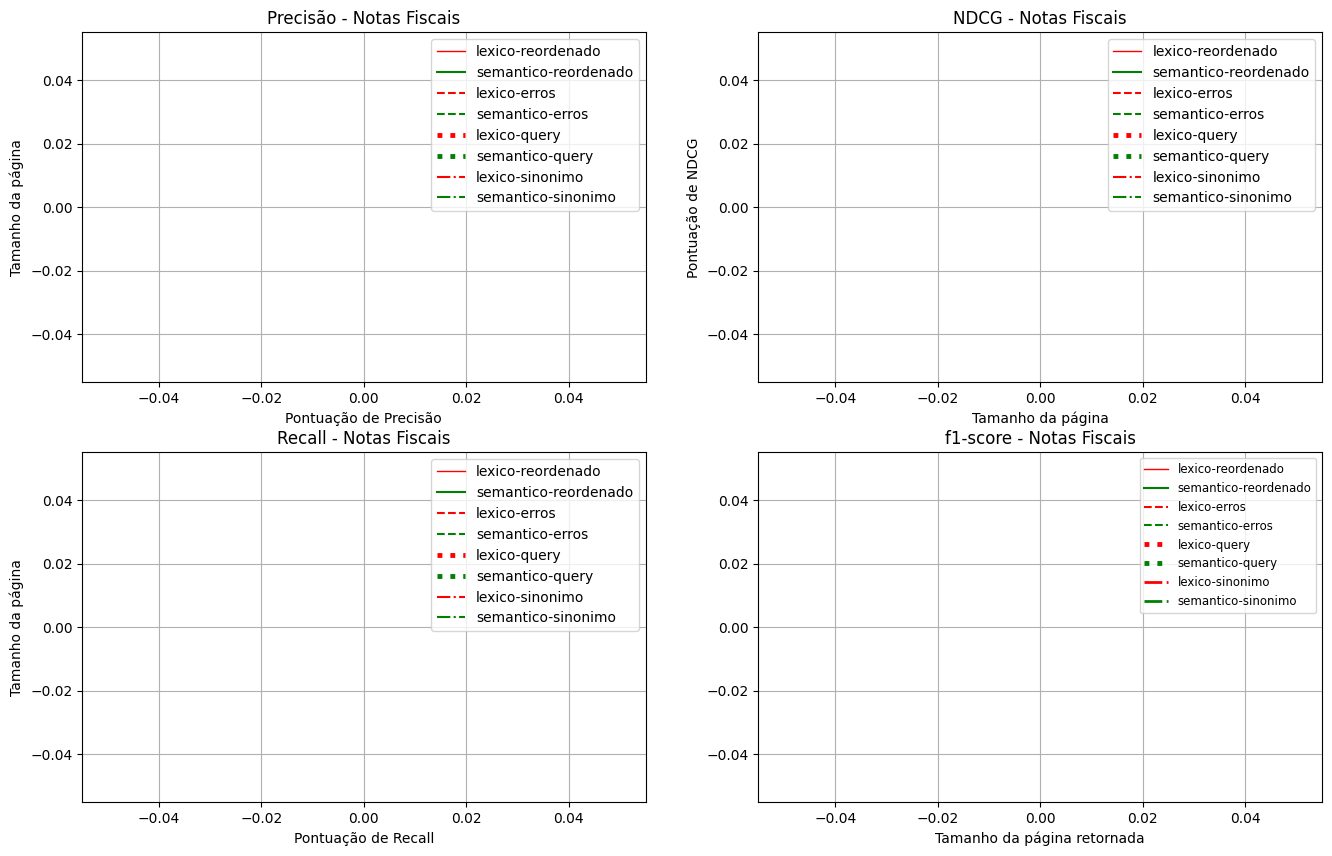

In [34]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Precisão - Notas Fiscais')
ax[0,0].set_xlabel('Pontuação de Precisão')
ax[0,0].set_ylabel('Tamanho da página')
ax[0,0].plot(lexico['size_page'], lexico['ndcg_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(lexico['size_page'], lexico['ndcg_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[0,0].plot(lexico['size_page'], lexico['ndcg_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[0,0].plot(lexico['size_page'], lexico['ndcg_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('NDCG - Notas Fiscais')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação de NDCG')
ax[0,1].plot(lexico['size_page'], lexico['recall_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[0,1].plot(semantico['size_page'], semantico['recall_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[0,1].plot(lexico['size_page'], lexico['recall_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[0,1].plot(semantico['size_page'], semantico['recall_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[0,1].plot(lexico['size_page'], lexico['recall_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[0,1].plot(semantico['size_page'], semantico['recall_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[0,1].plot(lexico['size_page'], lexico['recall_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[0,1].plot(semantico['size_page'], semantico['recall_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[0,1].grid('major')
ax[0,1].legend()

ax[1,0].set_title('Recall - Notas Fiscais')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação de NDCG')
ax[1,0].set_title('Recall - Notas Fiscais')
ax[1,0].set_xlabel('Pontuação de Recall')
ax[1,0].set_ylabel('Tamanho da página')
ax[1,0].plot(lexico['size_page'], lexico['recall_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[1,0].plot(semantico['size_page'], semantico['recall_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[1,0].plot(lexico['size_page'], lexico['recall_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[1,0].plot(semantico['size_page'], semantico['recall_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[1,0].plot(lexico['size_page'], lexico['recall_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[1,0].plot(semantico['size_page'], semantico['recall_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[1,0].plot(lexico['size_page'], lexico['recall_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[1,0].plot(semantico['size_page'], semantico['recall_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[1,0].grid('major')
ax[1,0].legend()

ax[1,1].set_title('f1-score - Notas Fiscais')
ax[1,1].set_xlabel('Tamanho da página retornada')
ax[1,1].set_ylabel('')
ax[1,1].plot(lexico['size_page'], lexico['f1-score_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[1,1].plot(lexico['size_page'], lexico['f1-score_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[1,1].plot(lexico['size_page'], lexico['f1-score_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[1,1].plot(lexico['size_page'], lexico['f1-score_sinonimos'], label='lexico-sinonimo', color='red', linewidth=2, linestyle='-.')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_sinonimos'], label='semantico-sinonimo', color='green', linewidth=2, linestyle='-.')
ax[1,1].grid('major')
ax[1,1].legend(fontsize=8.5)

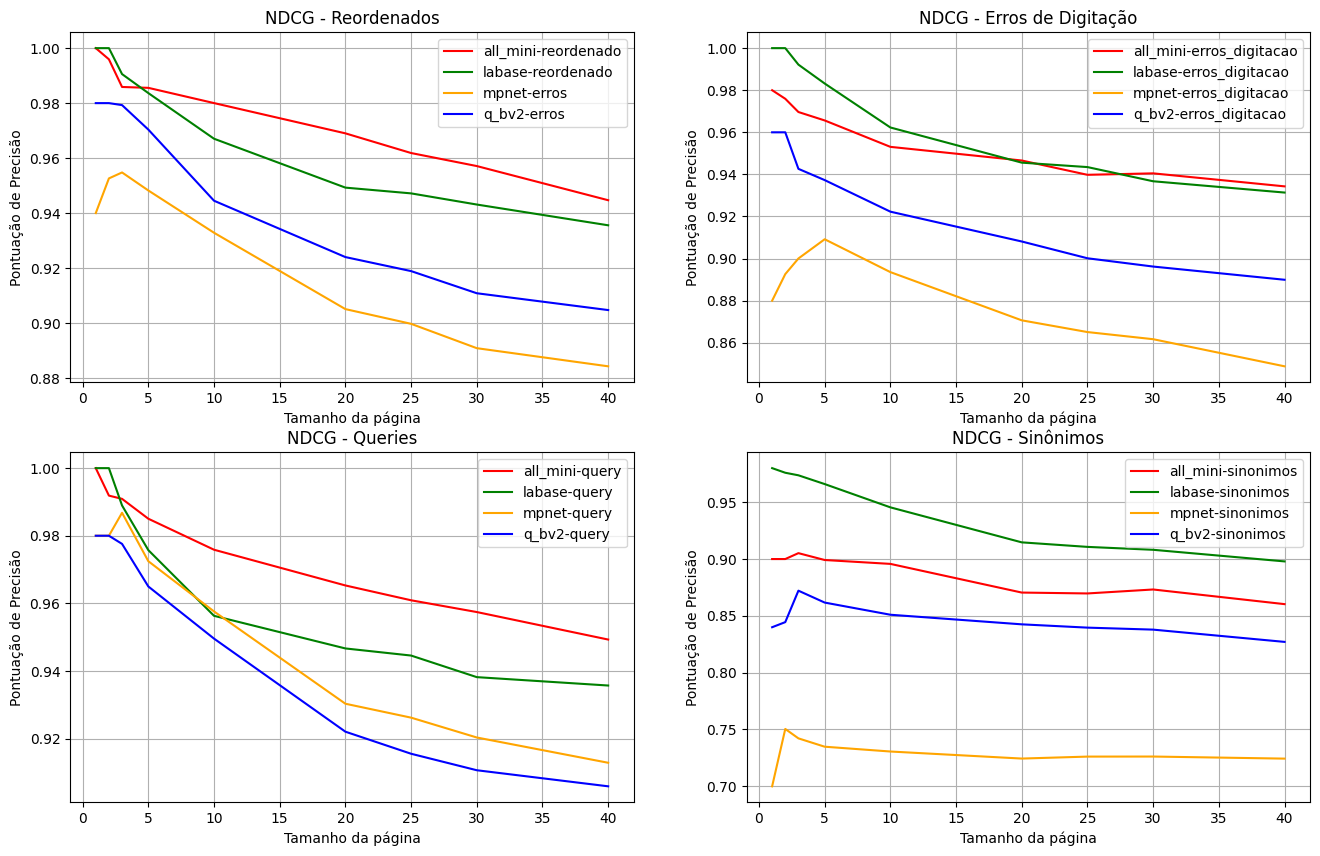

In [35]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('NDCG - Reordenados')
ax[0,0].set_xlabel('Tamanho da página')
ax[0,0].set_ylabel('Pontuação de Precisão')
ax[0,0].plot(all_mini['size_page'], all_mini['ndcg_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['ndcg_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['ndcg_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['ndcg_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('NDCG - Erros de Digitação')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação de Precisão')
ax[0,1].plot(all_mini['size_page'], all_mini['ndcg_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['ndcg_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['ndcg_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['ndcg_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('NDCG - Queries')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação de Precisão')
ax[1,0].plot(all_mini['size_page'], all_mini['ndcg_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['ndcg_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['ndcg_query'], label='mpnet-query', color='orange', linestyle='-')
ax[1,0].plot(q_bv2['size_page'], q_bv2['ndcg_query'], label='q_bv2-query', color='blue', linestyle='-'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('NDCG - Sinônimos')
ax[1,1].set_xlabel('Tamanho da página')
ax[1,1].set_ylabel('Pontuação de Precisão')
ax[1,1].plot(all_mini['size_page'], all_mini['ndcg_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['ndcg_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['ndcg_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['ndcg_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



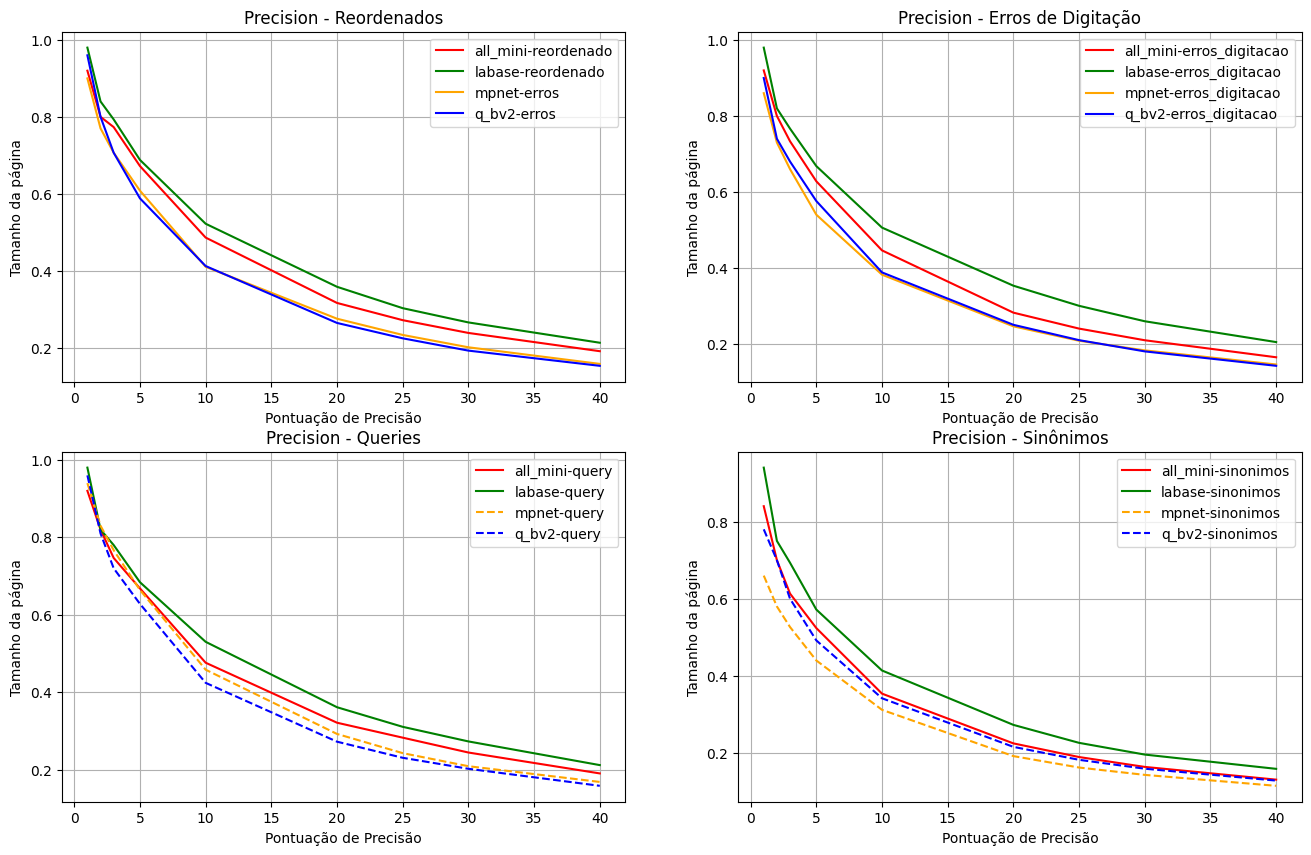

In [36]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Precision - Reordenados')
ax[0,0].set_xlabel('Pontuação de Precisão')
ax[0,0].set_ylabel('Tamanho da página')
ax[0,0].plot(all_mini['size_page'], all_mini['precision_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['precision_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['precision_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['precision_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('Precision - Erros de Digitação')
ax[0,1].set_xlabel('Pontuação de Precisão')
ax[0,1].set_ylabel('Tamanho da página')
ax[0,1].plot(all_mini['size_page'], all_mini['precision_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['precision_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['precision_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['precision_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('Precision - Queries')
ax[1,0].set_xlabel('Pontuação de Precisão')
ax[1,0].set_ylabel('Tamanho da página')
ax[1,0].plot(all_mini['size_page'], all_mini['precision_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['precision_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['precision_query'], label='mpnet-query', color='orange', linestyle='--')
ax[1,0].plot(q_bv2['size_page'], q_bv2['precision_query'], label='q_bv2-query', color='blue', linestyle='--'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('Precision - Sinônimos')
ax[1,1].set_xlabel('Pontuação de Precisão')
ax[1,1].set_ylabel('Tamanho da página')
ax[1,1].plot(all_mini['size_page'], all_mini['precision_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['precision_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['precision_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='--')
ax[1,1].plot(q_bv2['size_page'], q_bv2['precision_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='--'  )
ax[1,1].legend()
ax[1,1].grid('major')



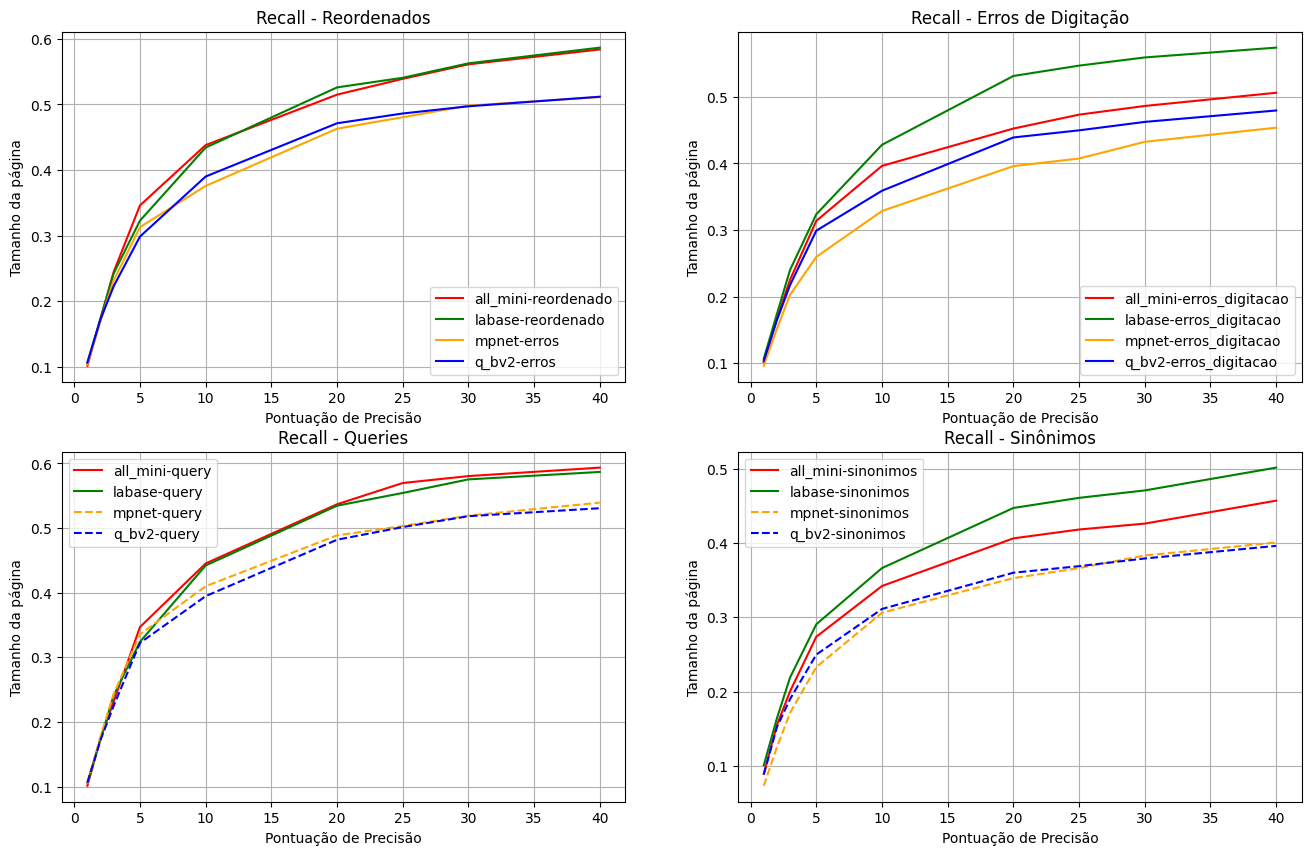

In [37]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Recall - Reordenados')
ax[0,0].set_xlabel('Pontuação de Precisão')
ax[0,0].set_ylabel('Tamanho da página')
ax[0,0].plot(all_mini['size_page'], all_mini['recall_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['recall_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['recall_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['recall_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('Recall - Erros de Digitação')
ax[0,1].set_xlabel('Pontuação de Precisão')
ax[0,1].set_ylabel('Tamanho da página')
ax[0,1].plot(all_mini['size_page'], all_mini['recall_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['recall_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['recall_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['recall_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('Recall - Queries')
ax[1,0].set_xlabel('Pontuação de Precisão')
ax[1,0].set_ylabel('Tamanho da página')
ax[1,0].plot(all_mini['size_page'], all_mini['recall_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['recall_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['recall_query'], label='mpnet-query', color='orange', linestyle='--')
ax[1,0].plot(q_bv2['size_page'], q_bv2['recall_query'], label='q_bv2-query', color='blue', linestyle='--'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('Recall - Sinônimos')
ax[1,1].set_xlabel('Pontuação de Precisão')
ax[1,1].set_ylabel('Tamanho da página')
ax[1,1].plot(all_mini['size_page'], all_mini['recall_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['recall_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['recall_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['recall_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



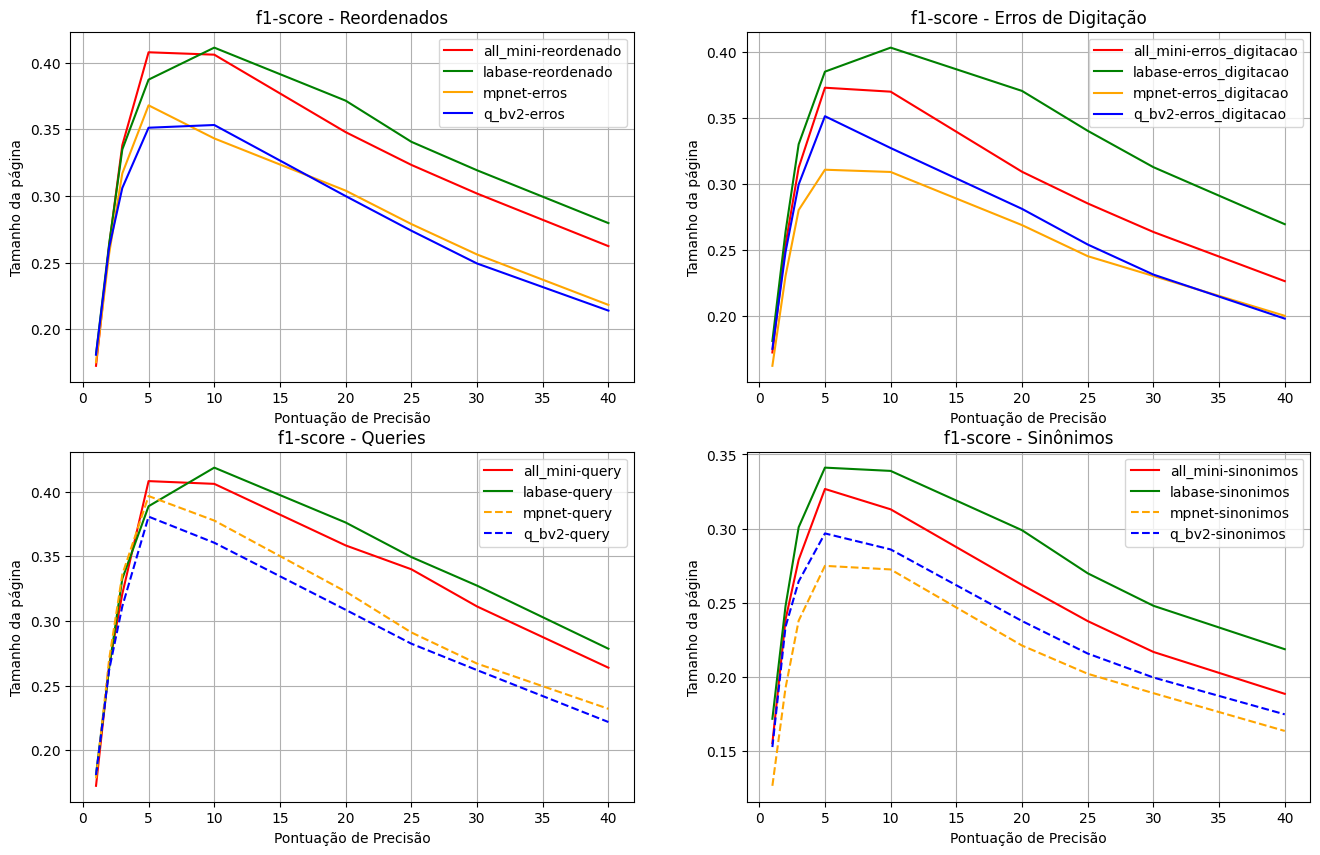

: 

In [38]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('f1-score - Reordenados')
ax[0,0].set_xlabel('Pontuação de Precisão')
ax[0,0].set_ylabel('Tamanho da página')
ax[0,0].plot(all_mini['size_page'], all_mini['f1-score_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['f1-score_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['f1-score_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['f1-score_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('f1-score - Erros de Digitação')
ax[0,1].set_xlabel('Pontuação de Precisão')
ax[0,1].set_ylabel('Tamanho da página')
ax[0,1].plot(all_mini['size_page'], all_mini['f1-score_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['f1-score_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['f1-score_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['f1-score_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('f1-score - Queries')
ax[1,0].set_xlabel('Pontuação de Precisão')
ax[1,0].set_ylabel('Tamanho da página')
ax[1,0].plot(all_mini['size_page'], all_mini['f1-score_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['f1-score_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['f1-score_query'], label='mpnet-query', color='orange', linestyle='--')
ax[1,0].plot(q_bv2['size_page'], q_bv2['f1-score_query'], label='q_bv2-query', color='blue', linestyle='--'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('f1-score - Sinônimos')
ax[1,1].set_xlabel('Pontuação de Precisão')
ax[1,1].set_ylabel('Tamanho da página')
ax[1,1].plot(all_mini['size_page'], all_mini['f1-score_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['f1-score_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['f1-score_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['f1-score_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

In [7]:
#!python -m spacy download pt_core_news_sm

nlp = spacy.load('pt_core_news_sm')
def custom_preprocessor(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

In [8]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor, lowercase=True, strip_accents='unicode', ngram_range=(1, 3))
tfidf_vectorizer.fit(df_index_catmat['MATERIAL_TEXT'])

TfidfVectorizer(ngram_range=(1, 3),
                preprocessor=<function custom_preprocessor at 0x7fe7e0623920>,
                strip_accents='unicode')

#Comparação do melhor semantico com o léxico